In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
# from imblearn import over_sampling, under_sampling
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import random
from sklearn.metrics import roc_auc_score
pd.options.display.max_columns = 100

In [3]:
%matplotlib inline

In [4]:
def standard_scale(x):
    res = (x - x.mean(axis = 0)) / x.std(axis = 0)
    return res

In [5]:
def e_metrics(x1, x2):
    distance = np.sum(np.square(x1 - x2))
    return np.sqrt(distance)

In [6]:
def accuracy(pred, y):
    return (sum(pred == y) / len(y))

In [7]:
# Метод kNN
def knn_w(x_train, y_train, x_test, k, is_debug = False):
    answers = []
    
    for index, x in enumerate(x_test):
           
        distances = np.sqrt( np.sum(np.square(x - x_train), axis = 1))
        test_distances = np.c_[distances, y_train]
        
        #----------------------------------------------------------------------------------------
        # создаем словарm со всеми возможными классами
        classes_weight = {class_item: 0 for class_item in set(y_train)}

        #----------------------------------------------------------------------------------------
        # Сортируем список и среди первых k элементов подсчитаем
        q = 0.2
        for d in sorted(test_distances, key = lambda x: x[0])[0:k]:
            classes_weight[d[1]] += round(q ** d[0], 6)  # метод с весами
        
        # выбираю классы методом с весами
        method_weight  = sorted(classes_weight, key = classes_weight.get)[-1]
        
        #----------------------------------------------------------------------------------------
        # В список ответов записываю класс с максимальным весом
        answers.append(method_weight)

        if (index % 500 == 0) and (is_debug):
            print(f'i = {index}; class_weight = {method_weight}; classes_weight = {classes_weight}')
        
    return answers

In [8]:
#------------------------------------------------------------------------------------------------------------
# Оценка качества: Матрица ошибок
def metric_error_matrix(y_pred, y_test):

    TP = FP = FN = TN = 0
    for i, pred in enumerate(y_pred):
    
        test = y_test[i]
        if pred == 1 and test == 1:
            TP += 1                    # True Positive
        elif pred == 1 and test == 0:
            FP += 1                    # False Positive
        elif pred == 0 and test == 1:
            FN += 1                    # False Negative
        else:
            TN += 1                    # True Negative
    
    # сама матрица ошибок
    error_matrix = np.zeros( (2, 2), dtype = np.int32)
    
    error_matrix[0, 0] = TP
    error_matrix[0, 1] = FP
    error_matrix[1, 0] = FN
    error_matrix[1, 1] = TN
    
    return error_matrix

#------------------------------------------------------------------------------------------------------------
# Оценка качества: TPR; Полнота (Recall)
def metric_tpr(y_pred, y_test):

    em = metrics_error_matrix(y_pred, y_test)
    result = 0
    
    if em[0, 0] + em[1, 0] != 0:
        result = em[0, 0] / (em[0, 0] + em[1, 0])
    
    return result

#------------------------------------------------------------------------------------------------------------
# Оценка качества: FPR; Доля ложных срабатываний
def metric_fpr(y_pred, y_test):

    em = metric_error_matrix(y_pred, y_test)
    result = 0
    
    if em[0, 1] + em[1, 1] != 0:
        result = em[0, 0] / (em[0, 1] + em[1, 1])
    
    return result

In [9]:
def calc_mse(y, y_pred):
    err = np.mean((y - y_pred)**2)
    return err

In [10]:
# Взаимная информация; Mutual Information; Расчет
def get_mi(x, y):
    mi = 0
#     cm = contingency_matrix(y, x)
    df_cm = pd.DataFrame(x)
    df_cm['target'] = y
    cm = pd.pivot_table(df_cm, index='target', columns=0, aggfunc=[len], fill_value = 0).to_numpy()
   
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            size = np.sum(cm)
            p_x_y = cm[i][j] / size
            p_x = np.sum(cm[:, j]) / size
            p_y = np.sum(cm[i]) / size

            if p_x_y == 0:
                continue
            mi += p_x_y * np.log(p_x_y / (p_x * p_y))
    return mi

In [11]:
# Взаимная информация; Mutual Information; Отображение
def mi_info(X):
    mi_res = []
    mi_sum = 0
    for i in range(0, X.shape[1]):
        mi = round(get_mi(X[:,  i], y), 8)
        mi_sum += mi
        mi_res.append( [i, mi, mi, df_X.columns[i]] )

        print(f'Признак {i}; MI = {mi}; {df_X.columns[i]}')
        
    print(f'sum MI = {mi_sum}')

    mi_res.sort(key=lambda x: x[1], reverse = True)
    
    print()
    for key, a in enumerate(mi_res):
        a[2] = round(a[1] / mi_sum * 100, 6)
        print(a)
    
    return mi_res

In [12]:
# Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [92]:
# Важность признаков
def show_features_importance(df):
    
    df = df[['feature', 'importance_proc']].sort_values(by = 'importance_proc', ascending = False).\
            rename(columns = {'feature': 'Feature', 'importance_proc': 'Importance'})

#     sns.set_context("paper", rc={"font.size":12,"axes.titlesize":12,"axes.labelsize":12})
    sns.set(font_scale = 1.2)
    
    fig, ax = plt.subplots()
    fig.set_size_inches(16, 10)

    sns.barplot(x = df['Importance'], y = df['Feature'], data = df, color = 'steelblue')#, cex.axis=1.5, cex.names=1.5))
    # 
    Yi = 0
    for Xi, value in zip(df['Importance'], df['Importance']):
        t = plt.text(Xi, Yi, round(value, 3), verticalalignment = 'center', size = 14,  weight = 'bold')
        Yi += 1

    plt.title('Features Importance', fontsize = 16, weight = 'bold')
    plt.xlabel('Importance', fontsize = 14, weight = 'bold')
    plt.ylabel('Features', fontsize = 14, weight = 'bold')

    plt.show()
    
    return df

### Функции подготовки данных

In [14]:
def data_prepare(df):
    
    print('Обработка крайних значений признаков')
    
    # Age
    print('\t age')
#     print(df['age'].min(), df['age'].mean(), df['age'].median(), df['age'].max())
    df.loc[df['age'] < 25, 'age'] = 25
    df.loc[df['age'] > 65, 'age'] = 65
#     print(df['age'].min(), df['age'].mean(), df['age'].median(), df['age'].max())

    # years_of_experience
    print('\t years_of_experience')
#     print(df['years_of_experience'].min(), df['years_of_experience'].mean(), 
#           df['years_of_experience'].median(), df['years_of_experience'].max())
    df.loc[df['years_of_experience'] > 6, 'years_of_experience'] = 6
#     print(df['years_of_experience'].min(), df['years_of_experience'].mean(), 
#           df['years_of_experience'].median(), df['years_of_experience'].max())

    # lesson_price
    print('\t lesson_price')
#     print(df['lesson_price'].min(), df['lesson_price'].mean(), df['lesson_price'].median(), df['lesson_price'].max())
    df.loc[df['lesson_price'] < 500, 'lesson_price'] = 500
    df.loc[df['lesson_price'] > 3000, 'lesson_price'] = 3000
#     print(df['lesson_price'].min(), df['lesson_price'].mean(), df['lesson_price'].median(), df['lesson_price'].max())

    # mean_exam_points
    print('\t mean_exam_points')
#     print(df['mean_exam_points'].min(), df['mean_exam_points'].mean(), 
#           df['mean_exam_points'].median(), df['mean_exam_points'].max())
    df.loc[df['mean_exam_points'] < 35, 'mean_exam_points'] = 35
    df.loc[df['mean_exam_points'] > 95, 'mean_exam_points'] = 95
#     print(df['mean_exam_points'].min(), df['mean_exam_points'].mean(), 
#           df['mean_exam_points'].median(), df['mean_exam_points'].max())

    #--------------------------------------------------------------------------------------------------------
    print('\nНовые признаки:')
    print('\t weight_param')
    print('\t mean_exam_points_group')
    print('\t lesson_price_group')

#     df['weight_param'] = ((df['lesson_price'] * 33.0  + df['mean_exam_points'] * 24.0 + df['age'] * 16.0 + \
#                          df['physics'] * 11.0 + df['years_of_experience'] * 9.0 + df['qualification'] * 7.0) / \
#                          (33.0 + 24.0 + 16.0 + 11.0 + 9.0 + 7.0) // 100 + 1) * 10

    df['weight_param'] = ((df['lesson_price'] * 15.0  + df['mean_exam_points'] * 14.0 + df['physics'] * 12.0 + \
                         df['years_of_experience'] * 2.0 + df['qualification'] * 2.0 + \
                           df['chemistry'] * 2.0 + df['age'] * 2.0 + df['biology'] * 2.0) / \
                         (15.0 + 14.0 + 12.0 + 2.0 + 2.0 + 2.0 + 2.0 + 2.0) // 100 + 1) * 10
    
    df['mean_exam_points_group'] = (df['mean_exam_points'] // 5 + 1) * 5
    df['lesson_price_group']     = (df['lesson_price'] // 200 + 1) * 200
    
    return df

In [15]:
def new_features_by_target(df):
    
    print('Новые вспомогательные признаки из целевой переменной')
    print('\t mean_exam_points_by_choose')
    print('\t lesson_price_by_choose')
    
    df['choose_1'] = (df['choose'] + 1) * 10

    df['mean_exam_points_by_choose'] = round((df['choose_1'] * 10  / df['mean_exam_points_group']), 1) * 10
    df['lesson_price_by_choose']     = round((df['choose_1'] * 100 / df['lesson_price_group']), 1) * 10

    df = df.drop('choose_1',        axis = 1)
    
    return df

#### Балансировка классов

In [16]:
# Классы в датасете несбаласированны
# пропорция: 0 класс - 89%; 1 класс - 11%
# дублирую данные 1-го класса до пропорции 50% на 50%
def class_balancing(df):

    print('Классы в исходном датасете несбалансированны')
    print('Пропорция: 0 класс - 89%; 1 класс - 11%')
    print()
    print(df.shape)
    print(df['choose'].value_counts(sort = False))

    for i in range(1, 8):
        df = pd.concat( [df, df_train.loc[ df_train['choose'] == 1]], axis = 0, ignore_index = True)
        
    print('\nДублирую данные 1-го класса до пропорции 50% на 50%')
    print()
    print(df.shape)
    print(df['choose'].value_counts(sort = False))
    
    return df

## 1. Исходные данные

In [17]:
df_train = \
    pd.read_csv('D:/WORK/BI/GeekBrains/Course_Data_Analysis_Algorithms/Course_Projects/Classification/train.csv', sep = ',')

### Тренировочный датасет

In [18]:
df_train.shape, df_train.columns

((10000, 13),
 Index(['Id', 'age', 'years_of_experience', 'lesson_price', 'qualification',
        'physics', 'chemistry', 'biology', 'english', 'geography', 'history',
        'mean_exam_points', 'choose'],
       dtype='object'))

In [19]:
df_train.head(5)

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points,choose
0,0,35.0,0.0,2150.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,74.0,0
1,1,52.0,2.0,1250.0,2.0,1.0,0.0,1.0,0.0,0.0,1.0,57.0,1
2,2,29.0,3.0,1750.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,66.0,0
3,3,33.0,3.0,1050.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,66.0,1
4,4,46.0,3.0,2250.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,73.0,0


In [20]:
df_train.describe()

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points,choose
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,4999.50000,45.800900,1.974800,1702.440000,1.724300,0.37060,0.121500,0.117200,0.059100,0.02770,0.018000,64.435200,0.110900
std,2886.89568,8.030274,1.766883,523.789062,0.798845,0.48299,0.326724,0.321675,0.235824,0.16412,0.132958,13.595024,0.314024
min,0.00000,23.000000,0.000000,200.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,33.000000,0.000000
25%,2499.75000,40.000000,0.000000,1300.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,55.000000,0.000000
50%,4999.50000,46.000000,2.000000,1550.000000,2.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,63.000000,0.000000
75%,7499.25000,51.000000,3.000000,2150.000000,2.000000,1.00000,0.000000,0.000000,0.000000,0.00000,0.000000,74.000000,0.000000
max,9999.00000,68.000000,9.000000,3950.000000,4.000000,1.00000,1.000000,1.000000,1.000000,1.00000,1.000000,100.000000,1.000000


In [21]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Id                   10000 non-null  int64  
 1   age                  10000 non-null  float64
 2   years_of_experience  10000 non-null  float64
 3   lesson_price         10000 non-null  float64
 4   qualification        10000 non-null  float64
 5   physics              10000 non-null  float64
 6   chemistry            10000 non-null  float64
 7   biology              10000 non-null  float64
 8   english              10000 non-null  float64
 9   geography            10000 non-null  float64
 10  history              10000 non-null  float64
 11  mean_exam_points     10000 non-null  float64
 12  choose               10000 non-null  int64  
dtypes: float64(11), int64(2)
memory usage: 1015.8 KB


### Распределение целевой переменной

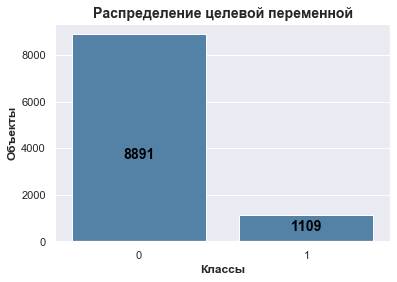

In [22]:
# Распределение целевой переменной
df_data = pd.DataFrame(df_train['choose'].value_counts()).reset_index().\
                        rename(columns = {'index': 'class', 'choose': 'count_obj'})
sns.set()

fig, ax1 = plt.subplots()
fig.set_size_inches(6, 4)

g = sns.barplot(x = 'class', y = 'count_obj', data = df_data, color = 'steelblue', ax = ax1 )

plt.title('Распределение целевой переменной', fontsize = 14, weight = 'bold')
plt.xlabel('Классы',  fontsize = 12, weight = 'bold')
plt.ylabel('Объекты', fontsize = 12, weight = 'bold')

for index, row in df_data.iterrows():
    g.text(row.name, row.count_obj - row.count_obj * 0.6, round(row.count_obj, 1), 
           color='black', ha="center", weight = 'bold', size = 14)

## 2. Предобработка данных

### Тренировочный датасет

In [23]:
df_train = data_prepare(df_train)

Обработка крайних значений признаков
	 age
	 years_of_experience
	 lesson_price
	 mean_exam_points

Новые признаки:
	 weight_param
	 mean_exam_points_group
	 lesson_price_group


In [24]:
df_train = new_features_by_target(df_train)

Новые вспомогательные признаки из целевой переменной
	 mean_exam_points_by_choose
	 lesson_price_by_choose


#### Вспомогательные таблицы

In [25]:
# Вспомогательные таблицы
# таблица с медианными коэффициентами по средним баллам по группам
df_exam_points = df_train.groupby(['mean_exam_points_group'], as_index = False).agg(
                                        {'mean_exam_points_by_choose':'median'})\
                                        .rename(columns={'mean_exam_points_by_choose':'exam_points_calc'})

# таблица с медианными коффициентами цен уроков по группам
df_lesson_price = df_train.groupby(['lesson_price_group'], as_index = False).agg({'lesson_price_by_choose':'median'})\
                                        .rename(columns={'lesson_price_by_choose':'lesson_price_calc'})

In [26]:
df_exam_points.head(), df_lesson_price.head()

(   mean_exam_points_group  exam_points_calc
 0                    40.0              25.0
 1                    45.0              22.0
 2                    50.0              20.0
 3                    55.0              18.0
 4                    60.0              17.0,
    lesson_price_group  lesson_price_calc
 0               600.0               33.0
 1               800.0               12.0
 2              1000.0               10.0
 3              1200.0                8.0
 4              1400.0                7.0)

In [27]:
df_train = df_train.merge(df_exam_points,  on = ['mean_exam_points_group'], how = 'left')
df_train = df_train.merge(df_lesson_price, on = ['lesson_price_group'],     how = 'left')

In [28]:
df_train.head(5)

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points,choose,weight_param,mean_exam_points_group,lesson_price_group,mean_exam_points_by_choose,lesson_price_by_choose,exam_points_calc,lesson_price_calc
0,0,35.0,0.0,2150.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,74.0,0,70.0,75.0,2200.0,13.0,5.0,13.0,5.0
1,1,52.0,2.0,1250.0,2.0,1.0,0.0,1.0,0.0,0.0,1.0,57.0,1,40.0,60.0,1400.0,33.0,14.0,17.0,7.0
2,2,29.0,3.0,1750.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,66.0,0,60.0,70.0,1800.0,14.0,6.0,14.0,6.0
3,3,33.0,3.0,1050.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,66.0,1,40.0,70.0,1200.0,29.0,17.0,14.0,8.0
4,4,46.0,3.0,2250.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,73.0,0,70.0,75.0,2400.0,13.0,4.0,13.0,4.0


## 3. Построение модели

### Балансировка классов

In [29]:
df_train = class_balancing(df_train)

Классы в исходном датасете несбалансированны
Пропорция: 0 класс - 89%; 1 класс - 11%

(10000, 20)
0    8891
1    1109
Name: choose, dtype: int64

Дублирую данные 1-го класса до пропорции 50% на 50%

(17763, 20)
0    8891
1    8872
Name: choose, dtype: int64


### Новое распределение целевой переменной

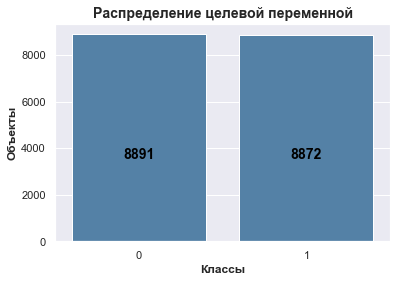

In [30]:
# Распределение целевой переменной
df_data = pd.DataFrame(df_train['choose'].value_counts()).reset_index().\
                        rename(columns = {'index': 'class', 'choose': 'count_obj'})
sns.set()

fig, ax1 = plt.subplots()
fig.set_size_inches(6, 4)

g = sns.barplot(x = 'class', y = 'count_obj', data = df_data, color = 'steelblue', ax = ax1 )

plt.title('Распределение целевой переменной', fontsize = 14, weight = 'bold')
plt.xlabel('Классы',  fontsize = 12, weight = 'bold')
plt.ylabel('Объекты', fontsize = 12, weight = 'bold')

for index, row in df_data.iterrows():
    g.text(row.name, row.count_obj - row.count_obj * 0.6, round(row.count_obj, 1), 
           color='black', ha="center", weight = 'bold', size = 14)

In [31]:
df_train.head(5)

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points,choose,weight_param,mean_exam_points_group,lesson_price_group,mean_exam_points_by_choose,lesson_price_by_choose,exam_points_calc,lesson_price_calc
0,0,35.0,0.0,2150.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,74.0,0,70.0,75.0,2200.0,13.0,5.0,13.0,5.0
1,1,52.0,2.0,1250.0,2.0,1.0,0.0,1.0,0.0,0.0,1.0,57.0,1,40.0,60.0,1400.0,33.0,14.0,17.0,7.0
2,2,29.0,3.0,1750.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,66.0,0,60.0,70.0,1800.0,14.0,6.0,14.0,6.0
3,3,33.0,3.0,1050.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,66.0,1,40.0,70.0,1200.0,29.0,17.0,14.0,8.0
4,4,46.0,3.0,2250.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,73.0,0,70.0,75.0,2400.0,13.0,4.0,13.0,4.0


### Признаки

In [32]:
feature_names = ['age', 'years_of_experience', 'lesson_price', 'qualification',
                'physics', 'chemistry', 'biology', 'english', 'geography', 'history', 'mean_exam_points', 
#                  'lesson_price_by_choose', 'mean_exam_points_by_choose',
                 'weight_param', 'mean_exam_points_group', 'lesson_price_group',
                 'exam_points_calc', 'lesson_price_calc',
                  'choose']
df_X = df_train[feature_names]
df_X.head(5)

,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points,weight_param,mean_exam_points_group,lesson_price_group,exam_points_calc,lesson_price_calc,choose
0,35.0,0.0,2150.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,74.0,70.0,75.0,2200.0,13.0,5.0,0
1,52.0,2.0,1250.0,2.0,1.0,0.0,1.0,0.0,0.0,1.0,57.0,40.0,60.0,1400.0,17.0,7.0,1
2,29.0,3.0,1750.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,66.0,60.0,70.0,1800.0,14.0,6.0,0
3,33.0,3.0,1050.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,66.0,40.0,70.0,1200.0,14.0,8.0,1
4,46.0,3.0,2250.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,73.0,70.0,75.0,2400.0,13.0,4.0,0


### Матрица корреляции признаков

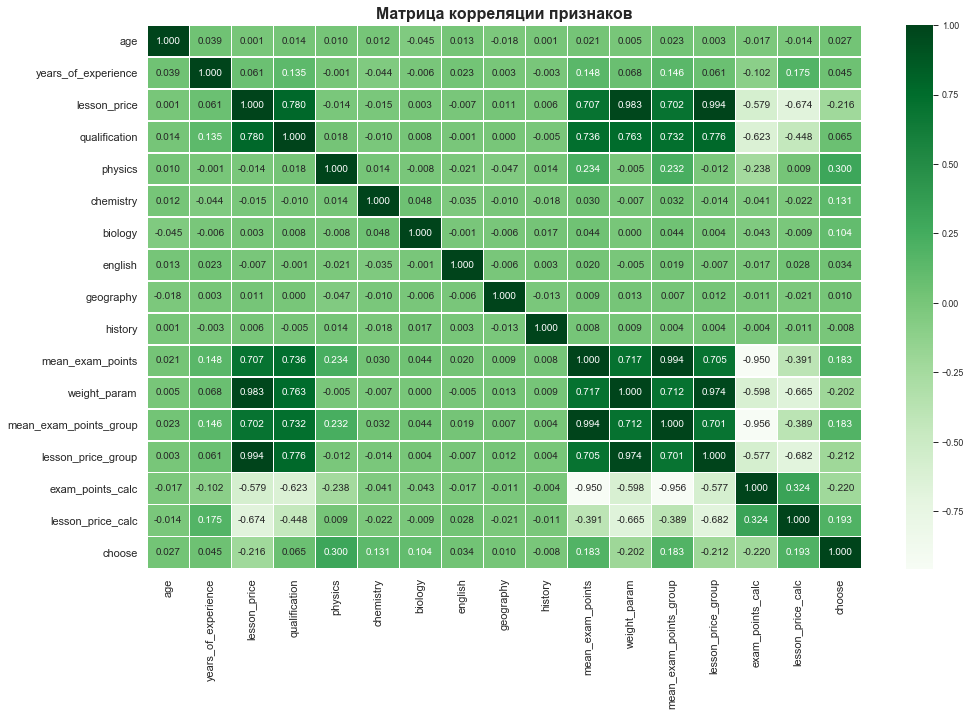

In [63]:
# df_X.corr()
sns.set()
fig, ax1 = plt.subplots()
fig.set_size_inches(16, 10)

sns.set_context("paper", rc={"font.size":10,"axes.titlesize":10,"axes.labelsize":10})  
sns.heatmap(df_X.corr(), annot=True, fmt=".3f", linewidths=.5, cmap="Greens")
plt.title('Матрица корреляции признаков', fontsize = 16, weight = 'bold')
plt.show()

### Данные для обучения

#### Целевая переменная и Тренировочный датасет

In [41]:
# целевая переменная choose
y = df_train['choose']
y.head(10)

# признаки для обучения
feature_names = ['age', 'years_of_experience', 'lesson_price', 'qualification',
               'physics', 'chemistry', 'biology', 
                 'english', 'geography', 'history', 
                 'mean_exam_points',
#                  'lesson_price_by_choose', 'mean_exam_points_by_choose',
                 'weight_param', 'mean_exam_points_group', 'lesson_price_group',
                'exam_points_calc', 'lesson_price_calc']

# df_X = df_train[feature_names]
X = df_train[feature_names]

#### DataFrame в Numpy и Стандартизация (масштабирование) признаков

In [42]:
X = X.to_numpy()
y = y.to_numpy()
X = X.astype(float)

X = standard_scale(X)

#### Разделение тренировочного датасета на учебные и проверочные данные

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 21, stratify = y)

### Обучение

#### Метод kNN

In [44]:
%%time
k = 31      # Получен перебором 

y_pred = knn_w(X_train, y_train, X_test, k, True)

i = 0; class_weight = 1; classes_weight = {0: 2.604239, 1: 7.0088300000000014}
i = 500; class_weight = 0; classes_weight = {0: 13.232774, 1: 0}
i = 1000; class_weight = 1; classes_weight = {0: 3.223757, 1: 4.555511999999999}
i = 1500; class_weight = 0; classes_weight = {0: 9.338576999999999, 1: 5.366882999999999}
i = 2000; class_weight = 1; classes_weight = {0: 1.040222, 1: 9.261711000000007}
i = 2500; class_weight = 0; classes_weight = {0: 4.519263, 1: 0.8009039999999998}
i = 3000; class_weight = 0; classes_weight = {0: 4.952072, 1: 0.39022}
i = 3500; class_weight = 1; classes_weight = {0: 3.400753, 1: 8.934099999999997}
Wall time: 1min 37s


#### Точность алгоритма ROC_AUC

In [45]:
print(f'\nТочность алгоритма при k = {k}:\n\t roc_auc = {roc_auc_score(y_pred, y_test):.6f}')


Точность алгоритма при k = 31:
	 roc_auc = 0.862406


### Важность признаков

In [46]:
df_feature_importances = pd.DataFrame(mi_info(X), columns = ['i', 'importance', 'importance_proc', 'feature'])

Признак 0; MI = 0.00684745; age
Признак 1; MI = 0.00227369; years_of_experience
Признак 2; MI = 0.05798453; lesson_price
Признак 3; MI = 0.00320738; qualification
Признак 4; MI = 0.0457953; physics
Признак 5; MI = 0.00867006; chemistry
Признак 6; MI = 0.00541079; biology
Признак 7; MI = 0.00056967; english
Признак 8; MI = 4.918e-05; geography
Признак 9; MI = 2.925e-05; history
Признак 10; MI = 0.05556653; mean_exam_points
Признак 11; MI = 0.03724194; weight_param
Признак 12; MI = 0.04443419; mean_exam_points_group
Признак 13; MI = 0.04701239; lesson_price_group
Признак 14; MI = 0.04427965; exam_points_calc
Признак 15; MI = 0.04145071; lesson_price_calc
sum MI = 0.40082271

[2, 0.05798453, 14.466378, 'lesson_price']
[10, 0.05556653, 13.863119, 'mean_exam_points']
[13, 0.04701239, 11.728974, 'lesson_price_group']
[4, 0.0457953, 11.425326, 'physics']
[12, 0.04443419, 11.085747, 'mean_exam_points_group']
[14, 0.04427965, 11.047191, 'exam_points_calc']
[15, 0.04145071, 10.341408, 'lesson_pr

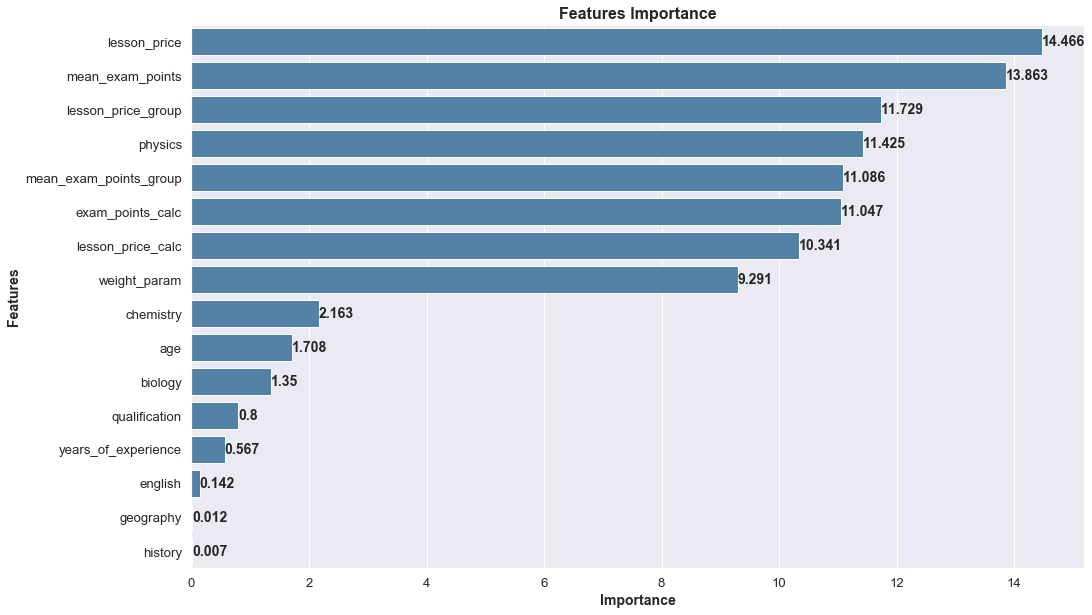

In [94]:
feature_importances = show_features_importance(df_feature_importances)

### Тестовый датасет

In [95]:
df_res = pd.read_csv( \
    'D:/WORK/BI/GeekBrains/Course_Data_Analysis_Algorithms/Course_Projects/Classification/test.csv', sep = ',')

In [96]:
df_res.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Id                   10000 non-null  int64  
 1   age                  10000 non-null  float64
 2   years_of_experience  10000 non-null  float64
 3   lesson_price         10000 non-null  float64
 4   qualification        10000 non-null  float64
 5   physics              10000 non-null  float64
 6   chemistry            10000 non-null  float64
 7   biology              10000 non-null  float64
 8   english              10000 non-null  float64
 9   geography            10000 non-null  float64
 10  history              10000 non-null  float64
 11  mean_exam_points     10000 non-null  float64
dtypes: float64(11), int64(1)
memory usage: 937.6 KB


In [97]:
df_res = data_prepare(df_res)
print()
df_res.info()

Обработка крайних значений признаков
	 age
	 years_of_experience
	 lesson_price
	 mean_exam_points

Новые признаки:
	 weight_param
	 mean_exam_points_group
	 lesson_price_group

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Id                      10000 non-null  int64  
 1   age                     10000 non-null  float64
 2   years_of_experience     10000 non-null  float64
 3   lesson_price            10000 non-null  float64
 4   qualification           10000 non-null  float64
 5   physics                 10000 non-null  float64
 6   chemistry               10000 non-null  float64
 7   biology                 10000 non-null  float64
 8   english                 10000 non-null  float64
 9   geography               10000 non-null  float64
 10  history                 10000 non-null  float64
 11  mean_exam_points    

In [98]:
df_res.head(5)

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points,weight_param,mean_exam_points_group,lesson_price_group
0,10000,32.0,2.0,2700.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,90.0,95.0,2800.0
1,10001,35.0,6.0,1800.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,71.0,60.0,75.0,2000.0
2,10002,44.0,2.0,1200.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,45.0,40.0,50.0,1400.0
3,10003,44.0,4.0,2950.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,92.0,90.0,95.0,3000.0
4,10004,38.0,3.0,1400.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,58.0,50.0,60.0,1600.0


#### Вспомогательные признаки

In [99]:
# Добавление вспомогательных признаков
df_res = df_res.merge( df_exam_points,  on = ['mean_exam_points_group'], how = 'left')
df_res = df_res.merge( df_lesson_price, on = ['lesson_price_group'],     how = 'left')

In [100]:
df_res.head(5)

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points,weight_param,mean_exam_points_group,lesson_price_group,exam_points_calc,lesson_price_calc
0,10000,32.0,2.0,2700.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,90.0,95.0,2800.0,11.0,4.0
1,10001,35.0,6.0,1800.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,71.0,60.0,75.0,2000.0,13.0,5.0
2,10002,44.0,2.0,1200.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,45.0,40.0,50.0,1400.0,20.0,7.0
3,10003,44.0,4.0,2950.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,92.0,90.0,95.0,3000.0,11.0,3.0
4,10004,38.0,3.0,1400.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,58.0,50.0,60.0,1600.0,17.0,6.0


In [101]:
# признаки для обучения
feature_names = ['age', 'years_of_experience', 'lesson_price', 'qualification',
               'physics', 'chemistry', 'biology', 
                 'english', 'geography', 'history', 
                 'mean_exam_points',
#                  'lesson_price_by_choose', 'mean_exam_points_by_choose',
                 'weight_param', 'mean_exam_points_group', 'lesson_price_group',
                'exam_points_calc', 'lesson_price_calc']
feature_names

['age',
 'years_of_experience',
 'lesson_price',
 'qualification',
 'physics',
 'chemistry',
 'biology',
 'english',
 'geography',
 'history',
 'mean_exam_points',
 'weight_param',
 'mean_exam_points_group',
 'lesson_price_group',
 'exam_points_calc',
 'lesson_price_calc']

In [102]:
X_res = df_res[feature_names]

X_res = X_res.to_numpy()
X_res = X_res.astype(float)
X_res = standard_scale(X_res)

#### Метод kNN

In [105]:
%%time
# Метод kNN
if True:
    y_res_preds = knn_w(X_train, y_train, X_res, k, True)
    print()

i = 0; class_weight = 0; classes_weight = {0: 5.290216000000001, 1: 0}
i = 500; class_weight = 0; classes_weight = {0: 1.5559530000000001, 1: 0.14352600000000001}
i = 1000; class_weight = 0; classes_weight = {0: 9.007018999999998, 1: 0}
i = 1500; class_weight = 1; classes_weight = {0: 3.6192060000000006, 1: 4.819642}
i = 2000; class_weight = 1; classes_weight = {0: 0.469752, 1: 1.1984329999999992}
i = 2500; class_weight = 1; classes_weight = {0: 0.65405, 1: 0.7062300000000001}
i = 3000; class_weight = 0; classes_weight = {0: 2.0310919999999997, 1: 1.8265899999999997}
i = 3500; class_weight = 0; classes_weight = {0: 7.576777, 1: 5.984361999999998}
i = 4000; class_weight = 1; classes_weight = {0: 1.437644, 1: 2.836675000000001}
i = 4500; class_weight = 0; classes_weight = {0: 7.282734999999999, 1: 1.7920489999999996}
i = 5000; class_weight = 0; classes_weight = {0: 10.747606999999997, 1: 0.938172}
i = 5500; class_weight = 1; classes_weight = {0: 1.6401480000000002, 1: 7.177158000000002}


#### Запись результатов предсказания

In [106]:
df_save = pd.DataFrame({'Id': df_res['Id'], 'choose': y_res_preds}, columns = ['Id', 'choose'])
df_save.head(10)

df_save.to_csv('mishenkov_predictions.csv', sep = ',', index = False)